## Code

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
import joblib



### Initial Data Exploration

In [2]:
df = pd.read_csv('/Users/zhuyuchen/Desktop/CMU MSBA/Mini 4/Machine Learning For Business Applications/hotel_booking.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.0,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [4]:
feature_simple = ['lead_time',
                 'arrival_date_year']

X = df[feature_simple]

y = df['is_canceled']

# Proceed with the train-test split as before
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=21)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

# Initialize logistic regression model with regularization (L2) and a high number of iterations
model_simple = LogisticRegression(penalty='l2', max_iter=100000)

# Fit the logistic regression model on the entire training data
model_simple.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = model_simple.predict(X_test_scaled)


# Save the model to a file
joblib.dump(model_simple, "simple_model.pkl")

['simple_model.pkl']

### Initial Data Cleaning

In [4]:
features = ['hotel',
            'lead_time',
            'arrival_date_year',
            'arrival_date_month', 
            'arrival_date_week_number',
            'arrival_date_day_of_month',
            'stays_in_weekend_nights',
            'stays_in_week_nights',
            'adults',
            'children',
            'babies',
            'meal',
            'country',
            'market_segment',
            'distribution_channel',
            'is_repeated_guest',
            'previous_cancellations',
            'previous_bookings_not_canceled',
            'reserved_room_type',
            'assigned_room_type',
            'booking_changes',
            'deposit_type',
            'days_in_waiting_list',
            'customer_type',
            'adr',
            'required_car_parking_spaces',
            'total_of_special_requests'   
]



In [5]:
X = df[features]
y = df['is_canceled']

# Identify categorical columns
categorical_columns = ['hotel', 'arrival_date_month', 'meal', 'arrival_date_year', 
                       'arrival_date_week_number', 'arrival_date_day_of_month', 'country', 'market_segment', 
                       'distribution_channel', 'reserved_room_type', 'assigned_room_type',  'deposit_type', 'customer_type']

# Create dummy variables for the categorical column
dummy_variables = pd.get_dummies(X[categorical_columns], drop_first=True)

# Concatenate dummy variables with the original DataFrame
X = pd.concat([X, dummy_variables], axis=1)

# Drop the original categorical column if needed
X.drop(categorical_columns, axis=1, inplace=True)

# Filling up NA for X with median of the variables
X.fillna(X.median(), inplace=True)

In [6]:
X

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,...,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,342,0,0,2,0.0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,1,0
1,737,0,0,2,0.0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,1,0
2,7,0,1,1,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,13,0,1,1,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,14,0,2,2,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,23,2,5,2,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
119386,102,2,5,3,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
119387,34,2,5,2,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
119388,109,2,5,2,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [7]:
# Proceed with the train-test split as before
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=21)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

### Logistic Regression

In [8]:
# Initialize logistic regression model with regularization (L2) and a high number of iterations
model = LogisticRegression(penalty='l2', max_iter=100000)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)

# Fit the logistic regression model on the entire training data
model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the logistic regression model
print("Logistic Regression Model:")
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())
print(classification_report(y_test, y_pred))

Logistic Regression Model:
Cross-Validation Scores: [0.8139994  0.81669159 0.82213581 0.81751825 0.82033026]
Mean CV Score: 0.8181350625008701
              precision    recall  f1-score   support

           0       0.82      0.91      0.86     22550
           1       0.81      0.66      0.73     13267

    accuracy                           0.82     35817
   macro avg       0.81      0.78      0.79     35817
weighted avg       0.82      0.82      0.81     35817



In [9]:

# Save the model to a file
joblib.dump(model, "logistic_regression_model.pkl")

['logistic_regression_model.pkl']

In [62]:
# Get the coefficients and feature names
coefficients = model.coef_[0]
feature_names = X.columns

# Print the coefficients with feature names
print("Coefficients:")
for feature_name, coef in zip(feature_names, coefficients):
    print(f"{feature_name}: {coef}")

Coefficients:
lead_time: 0.6518536451960504
stays_in_weekend_nights: 0.09042201330985537
stays_in_week_nights: 0.12361485729954406
adults: 0.11515850178169373
children: 0.0922756005197902
babies: 0.001805628079201554
is_repeated_guest: -0.16513182227183287
previous_cancellations: 1.8030747420452253
previous_bookings_not_canceled: -0.5443300624359666
booking_changes: -0.2329173322109106
days_in_waiting_list: -0.05260899038601957
adr: 0.3419096898998716
required_car_parking_spaces: -3.9365157831967186
total_of_special_requests: -0.6131099010786598
hotel_Resort Hotel: -0.03860494471972452
arrival_date_month_August: -0.1336407969484827
arrival_date_month_December: -0.00873257101896191
arrival_date_month_February: 0.01795832052821795
arrival_date_month_January: -0.02703027209126809
arrival_date_month_July: -0.16586927420900105
arrival_date_month_June: -0.07183774320780248
arrival_date_month_March: -0.03818854592544436
arrival_date_month_May: -0.025071254268066223
arrival_date_month_November

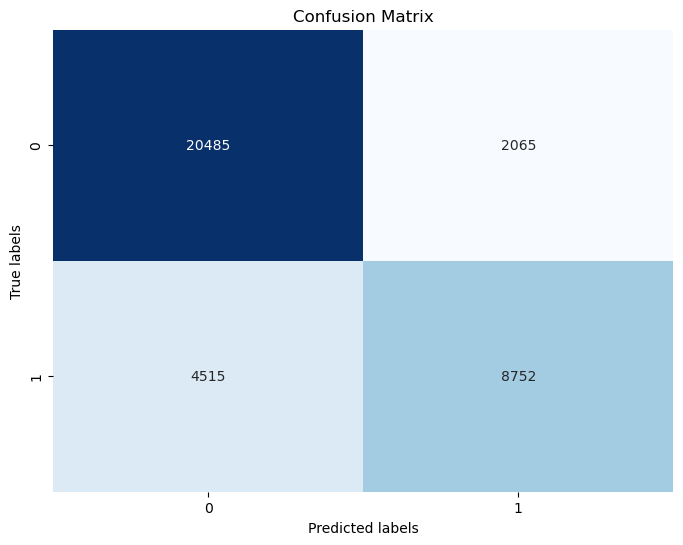

In [74]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

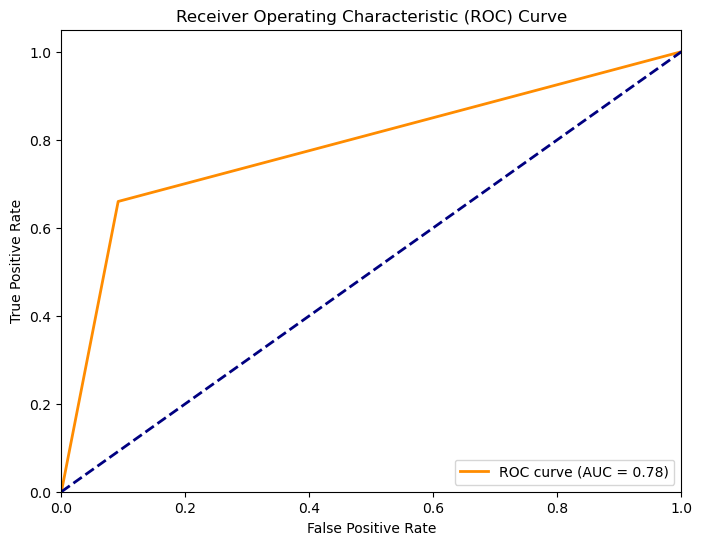

In [82]:
# Compute ROC curve and ROC area for each class
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Random Forest

In [10]:

# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5)

# Fit the Random Forest Classifier on the entire training data
rf_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate the Random Forest Classifier
print("Random Forest Classifier:")
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())
print(classification_report(y_test, y_pred_rf))

Random Forest Classifier:
Cross-Validation Scores: [0.87885133 0.8747233  0.88142387 0.88033983 0.87824578]
Mean CV Score: 0.8787168242371145
              precision    recall  f1-score   support

           0       0.88      0.93      0.91     22550
           1       0.88      0.79      0.83     13267

    accuracy                           0.88     35817
   macro avg       0.88      0.86      0.87     35817
weighted avg       0.88      0.88      0.88     35817



In [11]:
# Save the model to a file
joblib.dump(rf_model, "random_forest_model.pkl")

['random_forest_model.pkl']

In [65]:
# Get feature importances from the trained Random Forest model
importances = rf_model.feature_importances_

# Create a DataFrame to display feature importances
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Print or display the sorted feature importances
print(feature_importances_df)

                       Feature  Importance
0                    lead_time    0.146896
11                         adr    0.102864
237    deposit_type_Non Refund    0.095249
164                country_PRT    0.063357
13   total_of_special_requests    0.062351
..                         ...         ...
172                country_SDN    0.000000
125                country_LCA    0.000000
185                country_SYR    0.000000
50                 country_BHS    0.000000
138                country_MLI    0.000000

[242 rows x 2 columns]


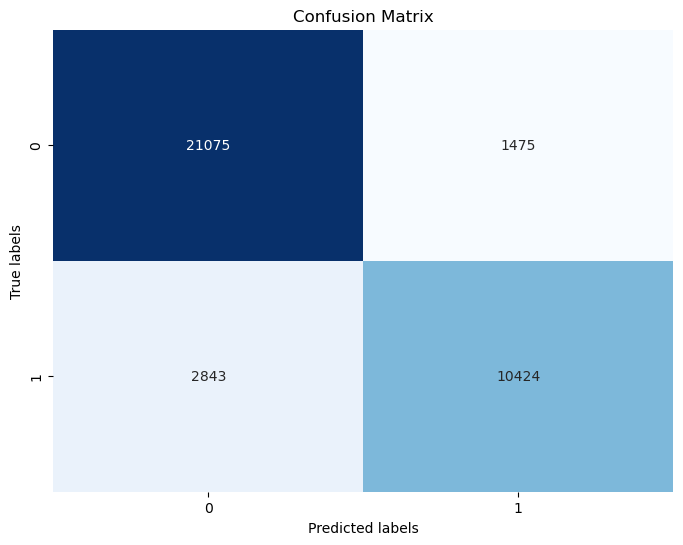

In [75]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

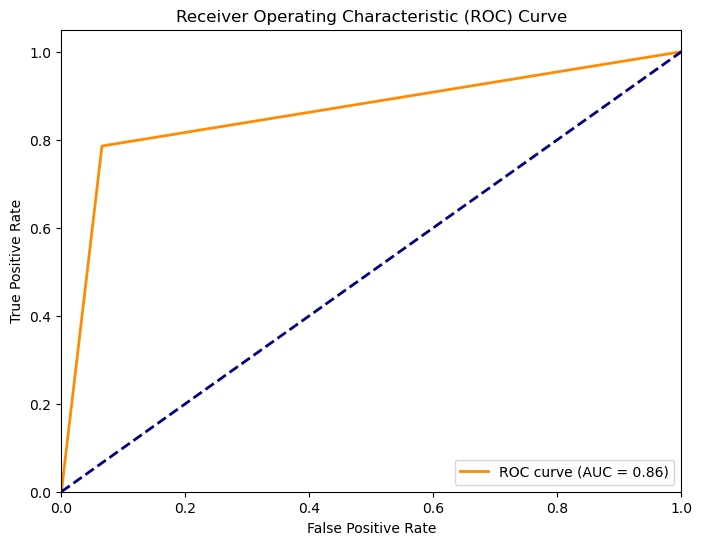

In [81]:
# Compute ROC curve and ROC area for each class
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()